# Exercise 5 - Random Forests 
Implementation of the Random Forest method and comparison with a shallow Neural Network


## Task 1

In this task we will introduce the most important concepts of decision trees by walking you through a simple example. On the way you have to solve some exercises to gain basic insights. We will start with a toy dataset and one tree (which will be extended to a whole forest in Task 3) ).
<br> <br>

In [1]:
from graphviz import Digraph
from graphviz import Source
from ipywidgets import interact, FloatSlider, IntSlider
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz


# Set random seed to ensure reproducible runs
RSEED = 50

In [2]:
# A simple data set for demonstration 
X = np.asarray(
    [[2, 2], 
    [2, 1],
    [2, 3], 
    [1, 2],
    [1, 1],
    [3, 3]]
)

y = np.asarray([0, 1, 1, 1, 0, 1])

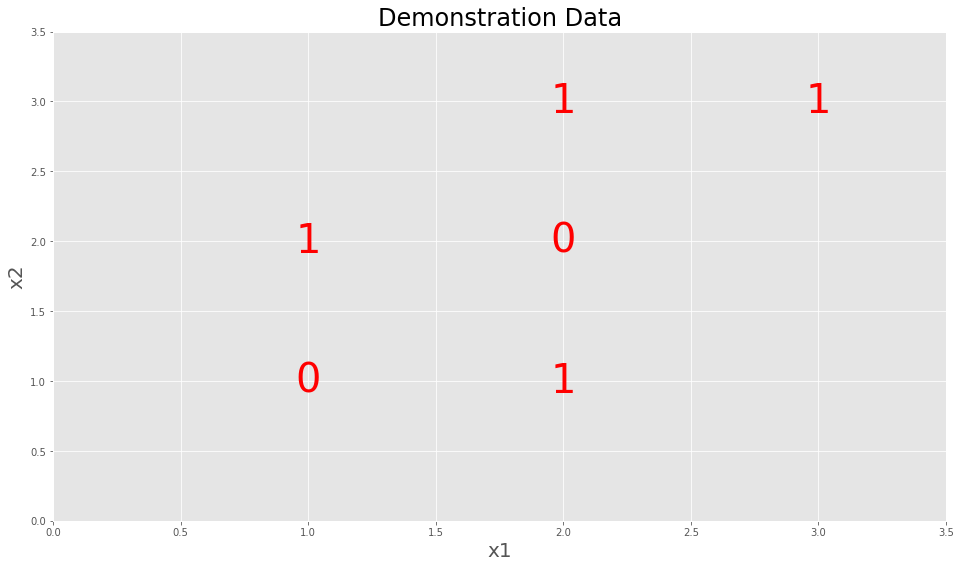

In [3]:
plt.figure(figsize=(16, 9))

for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, label, fontsize=40, color = 'r', ha='center', va='center')
    
plt.title('Demonstration Data', size = 24)
plt.xlim((0, 3.5))
plt.xlabel('x1', size = 20)
plt.ylim((0, 3.5))
plt.ylabel('x2', size = 20)
plt.show()

## Decision Tree Classifier (DTC)

A DTC builds a decision tree based on the features of the data. This is equivalent to subdividing the feature space. Let's consider the example above and apply a simple heuristics. In the first step we try to subdivide the space such that a maximum of the data points of the same class lie in one division.  
<br>
We first look at the feature $x_2$, i.e. a horizontal division of the space. For example, we could divide the space at the specific threshold $x_2 = 2.5$. Then we end up having a group of samples with features $x_2 > 2.5$ and homogenous class label 1, exactly the two points with coordinates $\{ (2,3), (3,3) \}$ . If we instead look at the feature $x_1$, corresponding to a vertical division of the space, we cannot find a equally large or larger group of samples with the same label. Therefore, our first node in the tree is: $x_2 \leq 2.5$, i.e. we split the space into two (see cell below) and repeat the same procedure on each of the two leafs. In our case we are done with the right leaf (since both samples have the same class) and only need to repeat the procedure on the left leaf.

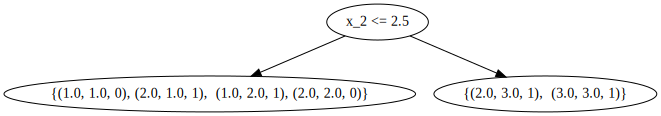

In [4]:
dot = Digraph()
dot.node('A', 'x_2 <= 2.5')
dot.node('B', '{(1.0,\ 1.0, 0),\ (2.0,\ 1.0, 1), \ (1.0,\ 2.0, 1), \(2.0,\ 2.0, 0)}')
dot.node('C', '{(2.0,\ 3.0, 1), \ (3.0,\ 3.0, 1)}')
dot.edges(['AB', 'AC'])
display(dot)

## Information Gain (IG) and Gini Impurity (GI)

Our simple heuristics from above fails on the left node. We need a better criterion to decide which splits to make. Two such criteria are called Information Gain and Gini Impurity. 
<br> <br>

### Information Gain
Information Gain [1] uses the notion of (Shannon) entropy [2]. The entropy of a discrete random variable $X$ with possible values $\{ x_1, \ldots, x_n\}$ is defined as 
$$ H(X) = - \sum_{i=1}^{n} P(x_i) \ log(P(x_i)) =  \sum_{i=1}^{n} P(x_i) \ I(x_i) = \mathbb{E}[I(X)], $$ where $I(x_i) = -log(P(x_i))$ is called the "self information" (note that we use that $ \underset{x \rightarrow 0^+}{lim} \ x \ log(x) = 0$). 
Entropy is the average information a random variable carries. The following exercises should demonstrate what that means. <br> 
Note: If log is the logarithm with base 2, information has the unit "bit". If we use the natural logarithm we have the unit "nat".  
<br> <br>
### Exercise
Consider a given dice. What is the entropy in "nats" if <br>
(A1) all the faces carry the same digit?

Let's call the digit $d$ and the number of faces $n$. 
$$
P(x = d) = 1
$$
$$
H(x) = - \sum_{i=1}^n P_i(x) \cdot \text{log}(P(x_i))
$$
In our case:
$$
H(x) = - \sum_{i=1}^6 P(x_i) \cdot \text{ln}(P(x_i)) \\
= - \sum_{i=1}^6 1 \cdot \text{ln}(1) \\
= - \sum_{i=1}^6 1 \cdot 0 \\
= 0 \ \text{nats} 
$$
(A2) all faces have a different digit? 

Let's call an arbitrary but fixed digit $d$ and the number of faces $n$. 
$$
P(x_i = d) = \frac{1}{n} 
$$
analogously to above we end up with
$$
H(x) = - \sum_{i=1}^n \frac{1}{n} \cdot \text{ln}(P(x_i)) \\
= - \sum_{i=1}^n \frac{1}{n} \cdot \text{ln}(\frac{1}{n}) \\
= - n \cdot \big( \frac{1}{n} \cdot \text{ln}(\frac{1}{n}) \big) \\
= - \text{ln}(\frac{1}{n}) \ \text{nats} 
$$

In the common case ($n = 6$) the entropy is $- \text{ln}(\frac{1}{6}) = 1.791759469228055 \ \text{nats}$

The above example should give an intuitive understanding about the connection of entropy and information. The dice with the same digit on every face carries no new information - every time you throw it you know the outcome already. Playing with such a dice would be rather boring.  <br>
Our data $Z$ itself also carries information - we can capture this by its entropy $H(Z)$.
### Exercise
(B1) Calculate the overall entropy in nats of our toy data from above

$$x_1 = x_4 = 0$$
$$x_2 = x_3 = x_5 = x_6 = 1$$

$$P(x_i = 0) = \frac{1}{3}$$
$$P(x_i = 1) = \frac{2}{3}$$

$$
H(Z) = -\sum_{i=1}^{\{1, 4\}} P(x_i) \cdot \text{ln}(P(x_i = 0)) -\sum_{i=1}^{\{2, 3, 5, 6\}} P(x_i) \cdot \text{ln}(P(x_i = 1)) \\
= - \big( \frac{1}{3} \cdot \text{ln}(\frac{1}{3}) \big) - \big( \frac{2}{3} \cdot \text{ln}(\frac{2}{3}) \big) \\
= 0.636514168 \ \text{nats} 
$$

<br>
Information Gain is a measure of how much information from the information of the parent leaf we could extract by applying a specific split. We will choose the split that lets us extract the most information. Suppose we split the data of the i-th node $Z$ into $k$ splits $Z_1, \ldots, Z_k$, then the information gain is 
$$ IG = H(Z,i) - \sum_{j=1}^{k} \frac{|Z_j|}{|Z|} H(Z_j), $$
where $| \bullet |$ denotes the number of elements of a set.

### Exercise:
The Information Gain for the split of our toy example is:
$$ IG = H(Z) - \frac{4}{6} H(left \ Leaf) - \frac{2}{6} H(right \ Leaf)~nats.$$
(C1) Evaluate the above expression
$$
H(\text{left}) = -2 \cdot \frac{2}{4} \cdot \text{ln}(\frac{2}{4}) = 0.6931471805 \ \text{nats}   
$$
$$
H(\text{right}) = -2 \cdot \frac{2}{2} \cdot \text{ln}(\frac{2}{2}) = 0 \ \text{nats}   
$$
Therefore
$$
IG = H(Z) - \frac{4}{6} \cdot H(\text{left}) - \frac{2}{6} \cdot H(\text{right}) = 0.1744160476267 \ \text{nats} 
$$
(C2) Calculate the Information Gain we would get if we split the dataset vertically at $x_1 = 1.5$
$$
H(\text{left}) = - \text{ln}(\frac{1}{2}) = 0.6931471805
$$
$$
H(\text{right}) = -\frac{3}{4} \cdot \text{ln}(\frac{3}{4}) - \frac{1}{4} \cdot \text{ln}(\frac{1}{4}) = 0.562335144 \ \text{nats}  
$$
Therefore
$$
IG = H(Z) - \frac{2}{6} \cdot H(\text{left}) - \frac{4}{6} \cdot H(\text{right}) = 0.03057501 \ \text{nats} 
$$

We see that the first split extracts more information. An alternative approach is the Gini impurity.

<br> <br>
### Gini impurity
The Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset [3].
<br>
What does that mean? Let us suppose we have $2$ labels and let $p_1, p_2$ be the fractions of points labeld with labels $1$ and $2$ (note: $p_1 + p_2 = 1$) . The probabilty to choose a point with label $1$ is $p_1$. 
The probability to choose label $2$ is $p_2 = 1-p_1$. Therefore, the probability to label a point of label $1$ with label $2$ is $p_1 \cdot p_2 = p_1 \cdot (1-p_1) = p_1 - p_1^2$. 
<br>
Analogously, the probability for points with label $2$ to be labeld with $1$ is $p_2 \cdot (1-p_2) = p_2 - p_2^2$. The Gini impurity is the sum over both: $p_1 - p_1^2 + p_2 - p_2^2 = p_1 + p_2 - p_1^2 - p_2^2 = 1 - p_1^2 -p_2^2$
<br>
The above reasoning is easy to generalize to the case where the number of labels $J$ is larger then two: $J > 2$ . The formula for the given dataset $Z$ is simply
$$I_G(Z) = 1 - \sum_{j = 1}^J p_j(Z)^2,$$ where $p_j(Z)$ is the frequency of points with labels $j$ in the dataset $Z$.
<br>
(D1) Calculate the Gini impurity for our toy dataset!
$$
I_G(Z) = 1 - \sum_{j=1}^J p_j(Z)^2 = 1 - (\frac{2}{6})^2 - (\frac{4}{6})^2 = \frac{16}{36} = \frac{4}{9}
$$
(D2) Calculate the Gini impurity for the left leaf in our split!
$$
I_G(\text{left}) = 1 - \sum_{j=1}^J p_j(Z)^2 = 1 - (\frac{2}{4})^2 - (\frac{2}{4})^2 = \frac{1}{2}
$$
(D3) Calculate the Gini impurity for the right leaf in our split!
$$
I_G(\text{left}) = 1 - \sum_{j=1}^J p_j(Z)^2 = 1 - 0^2 - 1^2 = 0
$$

<br>
The Gini impurity Gain is the amount of "impurity" we get rid of for a specific split.
Let's assume we perform a specific split $Z_1, \ldots, Z_k$ of $Z$. Then the impurity gain is
$$g_G(Z) = I_G(Z) - \sum_{j=1}^K \frac{|Z_k|}{|Z|} \cdot I_G(Z_k)$$
(D4) Calculate the Gini information gain for our split in the toy dataset
$$
g_G(Z) = \frac{4}{9} - \frac{4}{6} \cdot \frac{1}{2} - \frac{2}{6} \cdot 0 \\
= \frac{4}{9} - \frac{3}{9} \\
= \frac{1}{9}
$$
<br> <br>
## So what is a random forest?
What we have seen so far is one decision tree. A forest consists of multiple trees. But every tree is trained on a) a random subset of points and b) a random subset of features. a) is called "bagging" and reduces the variance of the model. b) is called "feature bagging" and is  applied because very view features might be strong predictors for the output - thus, many trees in our forest would be highly correlated which would counteract a). 

<br> <br>
[1] https://en.wikipedia.org/wiki/Information_gain_in_decision_trees <br>
[2] https://en.wikipedia.org/wiki/Entropy_(information_theory) <br>
[3] https://en.wikipedia.org/wiki/Decision_tree_learning

## Task 2: Train a dicision tree! 
In the Cells below there are code snippets you have to fill in!

In [5]:
tree = DecisionTreeClassifier().fit(X, y)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')
print(f'Model Accuracy: {tree.score(X, y)}')

Decision tree has 9 nodes with maximum depth 3.
Model Accuracy: 1.0


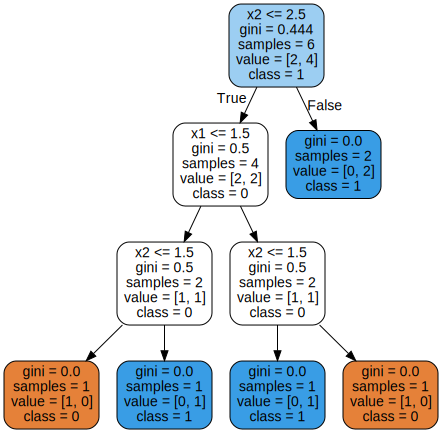

In [6]:
# Export as dot
dot_data = export_graphviz(tree, 'tree.dot', rounded=True, feature_names = ('x1', 'x2'), 
                class_names = ('0', '1'), filled=True, impurity=True)

Source.from_file("tree.dot")

# Real Dataset using Decision Trees
The following data set is from the Centers of Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals.

Download the '2015.csv' dataset from Moodle.

In [7]:
# read data: nothing to do here
# df = pd.read_csv('2015_health.csv').sample(100000, random_state=RSEED)
df = pd.read_csv('2015_health.csv', nrows=10_000)

# Only select floating/integer features (no strings) 
df = df.select_dtypes(['float'])

# Replace value 2 of feature '_RFHLTH' with 0
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()

# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])
df = df.dropna(axis=1, how='any')
df.head()

,_STATE,FMONTH,DISPCODE,SEQNO,_PSU,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,BLOODCHO,...,_PACAT1,_PAINDX1,_PA150R2,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3
0,1.0,1.0,1200.0,2.015000e+09,2.015000e+09,1.0,2.0,1.0,1.0,1.0,...,4.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0
1,1.0,1.0,1100.0,2.015000e+09,2.015000e+09,1.0,1.0,4.0,3.0,1.0,...,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,1.0,1.0,1200.0,2.015000e+09,2.015000e+09,2.0,2.0,1.0,3.0,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
3,1.0,1.0,1100.0,2.015000e+09,2.015000e+09,2.0,1.0,1.0,1.0,1.0,...,4.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0
4,1.0,1.0,1100.0,2.015000e+09,2.015000e+09,1.0,2.0,1.0,3.0,1.0,...,4.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0


In [8]:
# Extract the labels
labels = np.array(df.pop('_RFHLTH'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(
    df, labels, stratify=labels, test_size=0.3, random_state=RSEED)

In [9]:
# TODO: Train the decision tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 1999 nodes with maximum depth 27.


In [10]:
# Make probability predictions
probs = tree.predict_proba(test)[:, 1]

In [11]:
def plot_ROC_curve(probs: np.ndarray, method: str = 'Decision tree'):
    tpr, fpr, threshold = roc_curve(test_labels, probs)
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'darkgray', label='PLR=1', dashes=[2, 2], linewidth=3)
    plt.plot(tpr, fpr, 'lightgreen', label=method, linewidth=3)
    plt.title('ROC curve', fontsize=16)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()
    
def plot_ROC_curve_all(probs, method):
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'darkgray', label='PLR=1', dashes=[2, 2], linewidth=3)

    for p, m, c in zip(probs, method, ['red', 'lightgreen', 'lightblue', 'yellow']):
        tpr, fpr, threshold = roc_curve(test_labels, p)
        plt.plot(tpr, fpr, color=c, label=m, linewidth=3)
    
    plt.title('ROC curve', fontsize=16)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

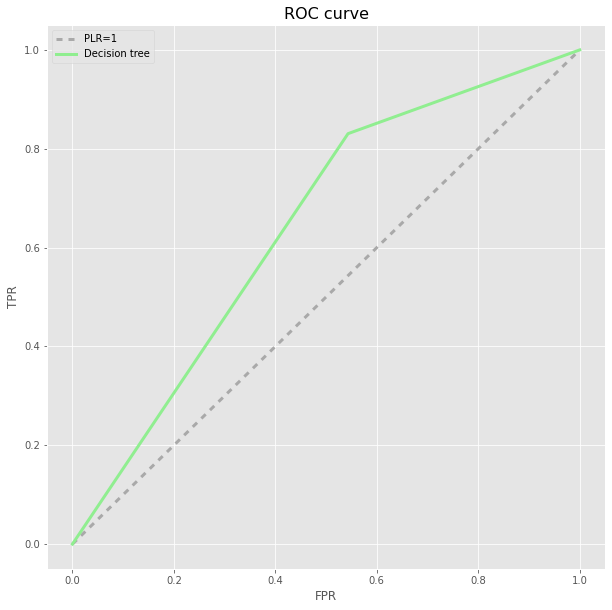

In [12]:
plot_ROC_curve(probs)

Random forests can be used to rank the importance of variables in a regression or classification problem in a natural way. To measure the importance of the $j$-th feature after training, the values of the $j$-th feature are permuted among the training data and the error is again computed on this perturbed data set. The importance score for the $j$-th feature is computed by averaging the difference in the error before and after the permutation over all trees. The score is normalized by the standard deviation of these differences.

In [13]:
fi = pd.DataFrame({'feature': df.columns,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(10)

,feature,importance
25,EMPLOY1,0.169435
34,_LLCPWT,0.056059
17,HAVARTH3,0.042613
1,FMONTH,0.037871
29,_STSTR,0.035684
16,CHCCOPD1,0.035275
32,_WT2RAKE,0.034279
54,_INCOMG,0.031121
4,_PSU,0.024379
21,MARITAL,0.022630


# Task 3: Real Dataset using Random Forest <br>
Use the RandomForestClassifier with 100 trees and perform the same steps as above <br> (create a model, train, test, plot the ROC curve, print the important features). <br> Discuss your results!

In [14]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(train, train_labels)

In [15]:
# Nothing to do here
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes: {np.mean(n_nodes)}')
print(f'Average maximum depth: {np.mean(max_depths)}')

Average number of nodes: 2041.74
Average maximum depth: 26.0


In [16]:
rf_probs = model.predict_proba(test)[:, 1]

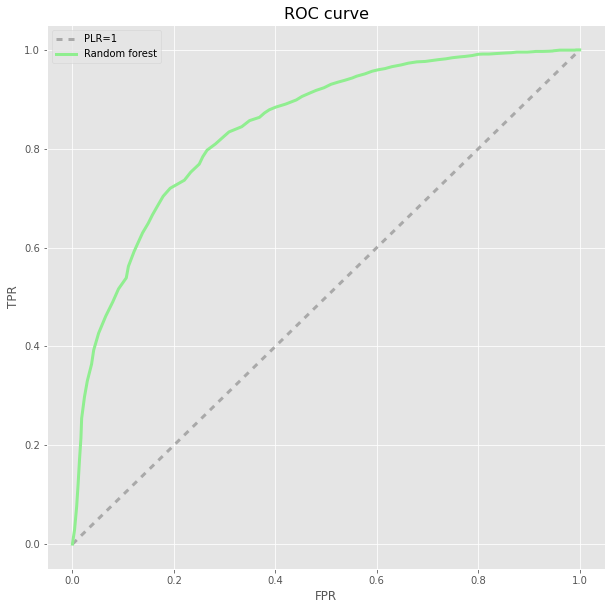

In [17]:
plot_ROC_curve(rf_probs, 'Random forest')

In [18]:
fi_model = pd.DataFrame({'feature': df.columns, 'importance': model.feature_importances_})
fi_model = fi_model.sort_values('importance', ascending=False)
fi_model.head(10)

,feature,importance
25,EMPLOY1,0.078016
34,_LLCPWT,0.035862
74,FC60_,0.033945
73,MAXVO2_,0.032275
54,_INCOMG,0.031152
17,HAVARTH3,0.029431
16,CHCCOPD1,0.028709
4,_PSU,0.028220
3,SEQNO,0.027952
49,_AGE80,0.027781


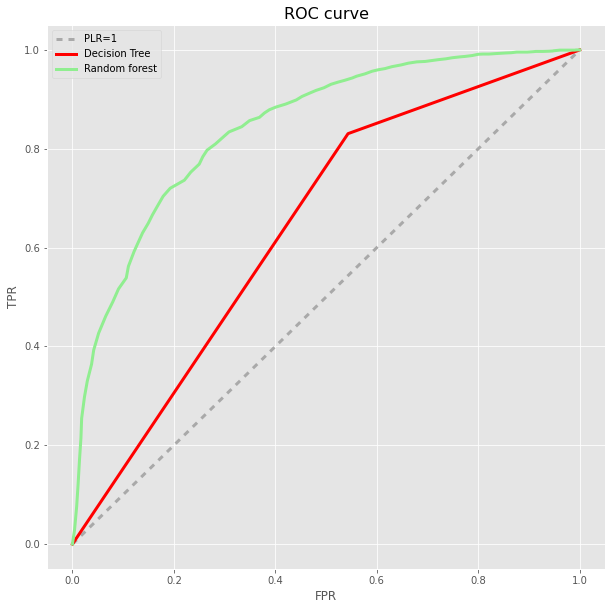

In [19]:
plot_ROC_curve_all([probs, rf_probs], ['Decision Tree', 'Random forest'])

## Discussion of Results

We can see that a `RandomForest` with `n_estimators=100` performs much better than `DecisionTree`. 

A `DecisionTree` learns the model by heart (=auswendig lernen) and thus overfits the train data (a lot).

A random Tree (100 of them form our `RandomForests`) performs worse on the trainset but retains the ability to predict future data. 

# Taskb3: Random Forest Optimization through Random Search
Performing a grid search to find optimal parameters. Warning: Depending on the chosen grid this might take some time... <br> What are the best parameters? <br> Perform the same steps as above (create a model, train, test, plot the ROC curve, print the important features). <br> Discuss your results! For this purpose, it might be a good idea to display all 4 ROC curves in a single plot.

In [20]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state=RSEED)

rs = RandomizedSearchCV(
    cv=3,
    estimator=estimator,
    n_jobs=-1,
    random_state=RSEED,
    param_distributions=param_grid
).fit(train, train_labels)

In [21]:
rs.best_params_

{'n_estimators': 29,
 'min_samples_split': 10,
 'max_leaf_nodes': 46,
 'max_depth': 14,
 'bootstrap': False}

In [22]:
best_model = rs.best_estimator_

In [23]:
rf_probs_3b = best_model.predict_proba(test)[:, 1]

In [24]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes: {int(np.mean(n_nodes))}')
print(f'Average maximum depth: {int(np.mean(max_depths))}')

Average number of nodes: 91
Average maximum depth: 10


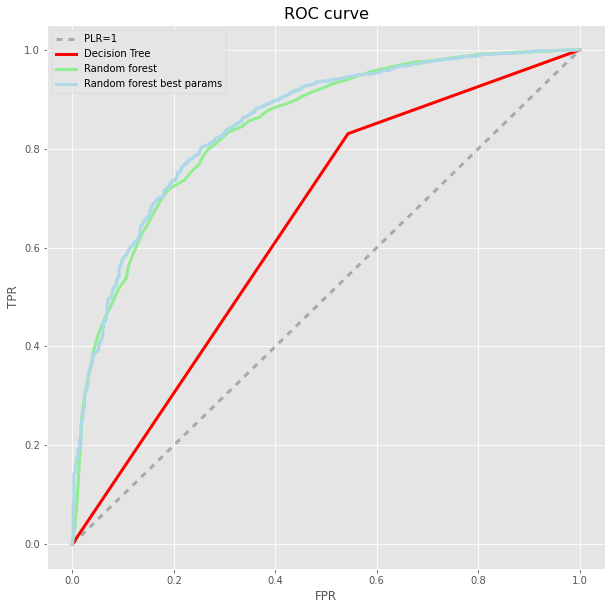

In [25]:
plot_ROC_curve_all(
    [probs, rf_probs, rf_probs_3b],
    ['Decision Tree', 'Random forest', 'Random forest best params']
)

## Discussion of Results

*(Not sure why there should be 4 ROC curves (`DecisionTree`, `RandomForest`, best parameters for `RandomForest`)? $\implies$ if you already counted the neural net see Task4)*

We can see that the `RandomForest` with the **best paramenters** overfits the model more than the default `RandomForest`. 

| Attribute | best `RandomForest` | default `RandomForest` ([scikit-learn v0.20.2](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) |
| --- | ------------------------------------- | --- |
| n_estimators | `29` | `20` |
| min_samples_split | `10` | `2` |
| max_leaf_nodes | `46` | unlimited |
| max_depth | `14` | Nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split samples` |
| bootstrap | `True` | `True` |

Therefore the default `RandomForest` performs better on the test data. 

# Task 4: Comparison with Shallow Neural Network
For comparison, train a NN on the same dataset. Chose your own parameters! What do you observe? How can these results be interpreted?  

In [26]:
@interact(solver=['sgd', 'lbfgs', 'adam'],
    activation=['logistic', 'identity', 'tanh', 'relu'],
    hidden_layer=IntSlider(min=50, max=200, value=125, step=5),
    maxiter=IntSlider(min=50, max=200, value=75, step=5),
    learn_rate=FloatSlider(min=0.01, max=0.1, step=0.01, value=0.05),
    verbose=[True, False])
def mlp_slider(solver: str, activation: str, hidden_layer: int, maxiter: int, learn_rate: float, verbose: bool = False):
    mlp = MLPClassifier(learning_rate_init=learn_rate, hidden_layer_sizes=hidden_layer, max_iter=maxiter, solver=solver, activation=activation, random_state=RSEED, verbose=verbose)
    mlp.fit(train,train_labels)
    
    print(f"Training set score: {mlp.score(train, train_labels)}")
    print(f"Test set score: {mlp.score(test, test_labels)}")
    print(f"Proportion of label 1 in dataset: {len(train[train_labels == 1]) / len(train)}")
    return mlp

Training set score: 0.760545193687231
Test set score: 0.7603748326639893
Proportion of label 1 in dataset: 0.760545193687231


MLPClassifier(activation='logistic', hidden_layer_sizes=125,
              learning_rate_init=0.05, max_iter=75, random_state=50,
              solver='sgd')

Training set score: 0.760545193687231
Test set score: 0.7603748326639893
Proportion of label 1 in dataset: 0.760545193687231


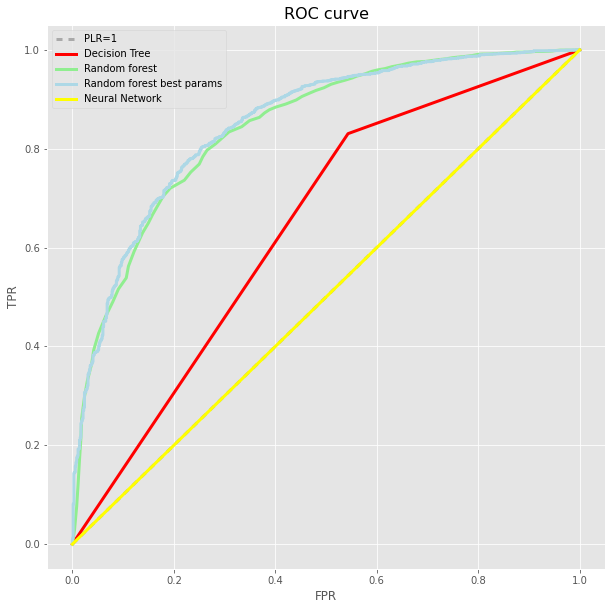

In [27]:
mlp = mlp_slider(solver='sgd', activation='logistic', hidden_layer=200, maxiter=75, learn_rate=0.05)
rf_probs_nn = mlp.predict_proba(test)[:, 1]

plot_ROC_curve_all([probs, rf_probs, rf_probs_3b, rf_probs_nn], ['Decision Tree', 'Random forest', 'Random forest best params', 'Neural Network'])

## Discussion of Results

We can observe that the Neural Network does not perform any better than just *the diagonal line* all the time. 

We can investigate that further:

In [28]:
mlp.predict_proba(test)[:, 1]

array([0.73678894, 0.73678894, 0.73678894, ..., 0.73678894, 0.73678894,
       0.73678894])

And indeed - the Neural Network returns the same prediction every time. A different parameter setting does not change that behavior at all: While the exact value of the returned values changes, the behavior of returning the same thing all the time does not.   